In [1]:
%load_ext autoreload
%autoreload 2
#python v3.11.3

In [2]:

import warnings
#to suppress seaborn palette warnings
warnings.filterwarnings("ignore", category=UserWarning)
#to suppress seaborn error estimation NaN warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

import os
import datetime

import numpy as np #v1.25.0
import pandas as pd #v2.0.3

import scipy #v1.10.1
import scipy.stats as stats
from scipy.optimize import curve_fit

import seaborn as sns #v0.13.0
import matplotlib as mpl #v3.8.1
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

from matplotlib.patches import Rectangle
from matplotlib.collections import LineCollection


# these files should be in the same directory as this Jupyter notebook
#from format_arduino_data import *
from lickfrequency_analysis import *
from plot_data import *

# to set styles for plotting
mpl.style.use(r"C:\Users\swind\Documents\lab_work\Barth\behavior_analysis\mouse_analysis\full_trial_analysis\mouse_analysis.mplstyle")

#to suppress inaccurate pandas reassignment warnings
pd.options.mode.chained_assignment = None  # default='warn'

In [3]:
def load_data(path, data_type, data_name, conds, dtype_map, cols):
    dataset  = []
    cols = cols.copy()
    for cond in conds:
        o_data = pd.read_csv(path + cond + '\\' + data_type + '_' + cond + '_' + data_name + '.txt', dtype=dtype_map)
        rm = []
        for c in cols:
            if c not in o_data.columns:
                rm.append(c)
        for c in rm:
            cols.remove(c)
        o_data = o_data[cols]
        dataset.append(o_data)
    dataset = pd.concat(dataset)
    dataset = dataset.replace({pd.NA:'u'})
    return dataset

def format_strain(df):
    df.loc[(df['Strain'] == 'SSTcre/Ai32-')|(df['Strain'] == 'Sscre x Ai32 -'), 'Strain'] = 'SSTcre x Ai32-'
    df.loc[(df['Strain'] == 'SSTcre x Ai32')|(df['Strain'] == 'Sscre x Ai32'), 'Strain'] = 'SSTcre x Ai32'
    df.loc[(df['Strain'] == 'SSTcre')|(df['Strain'] == 'Sscre'), 'Strain'] = 'SSTcre'
    df.loc[(df['Strain']=='Scnn-cre')|(df['Strain']=='Scnn-cre + 6OHDA')|(df['Strain']=='Scnn-cre+6OHDA partial'), 'Strain'] = 'Scnn-cre'
    df.loc[(df['Strain']=='.1-3/sscre'), 'Strain'] = '.1-3 x SSTcre'
    df.loc[df['Strain'] == '1-3 x Scnn-cre (1-3 WT)', 'Strain'] = '.1-3- x Scnn-cre'
    df.loc[df['Strain'] == '1-3 x Scnn-cre (1-3 Het)', 'Strain'] = '.1-3+ x Scnn-cre'

def format_condition(df):
    df["cond"] = df["condition"].replace({"hm4di_cno": "hM4Di + CNO", "mcherry_cno": "mCherry + CNO", 
                            '0.1 mg DCZ hm4di': "hM4Di + DCZ", 
                            '0.1 mg DCZ mcherry': "mCherry + DCZ", 
                            '0.5 mg DCZ mcherry':"mCherry + DCZ",  
                            '0.5 mg DCZ hm4di': "hM4Di + DCZ",
                            '100acc80acc':'100ACC80ACC',
                            "all_reward": "100ACC80SAT",
                            "SAT": "SAT", 'sat1':'SAT', 'sat5':'SAT', 
                            'SAT1':'SAT', 'SAT2':'SAT','SAT5':'SAT',
                            'acc2':'ACC', 'acc3':'ACC', 'acc7':'ACC',
                            'Ipsi-lesion':'Ipsi-lesion', 
                            'Contra-lesion':'Contra-lesion'})
    df['test_time'] = 'train'
    df.loc[df['condition'].str.contains('train'), 'cond'] = df.loc[df['condition'].str.contains('train'), 'condition'].str.rstrip('retrain').str.rstrip(' ')
    df.loc[df['condition'].str.contains('ipsi'), 'cond'] = 'ipsi lesion'
    df.loc[df['condition'].str.contains('sham'), 'cond'] = 'sham lesion'
    df.loc[df['condition'].str.contains('train'), 'test_time'] = df.loc[df['condition'].str.contains('train'), 'condition'].str.lstrip('contrlaipshm').str.lstrip(' ').str.lstrip('lesion').str.lstrip(' ')
    df.loc[df['test_time'].str.contains('retrain'), 'test_time'] = '5d test'
    df.loc[df['condition'].str.contains('test'), 'cond'] = df.loc[df['condition'].str.contains('test'), 'condition'].str.rstrip('test').str.rstrip(' ')
    df.loc[df['condition'].str.contains('test'), 'test_time'] = '21d test'

def format_cage(df):
    df['Cage'] = df['Cage'].str.upper()
    df.loc[df['Cage'] == 'UNKNOWN', 'Cage'] = 'U'
    df.loc[df['Cage'].isna(), 'Cage'] = 'U'

def format_all(df):
    if df['Day'].all():
        df['Day'] = df['Day'].apply(day_to_label)
    format_cage(df)
    format_strain(df)
    format_condition(df)

In [4]:
dtype_map = {'condition':str,'animal':str, 'stimulus':str, 'lick':float, 'Strain':str, 'Cage':str, 'type':str, 'Time (ms)':float, 'Time (hr)':float, 'Day':float, 'water':str}
perf_cols = ['condition', 'animal', 'Strain', 'Age', 'Cage', 'Date', 'acc', 'Time (hr)', 'Day']
lf_cols = perf_cols + ['stimulus', 'water', 'type']
conds = ['dcz']
data_path = 'C:\\Users\\swind\\Documents\\lab_work\\Barth\\behavior_analysis\\behavior_data\\analyzed\\'
to_load = {'full means':'', 'full performance':'', 'anticipatory means':'', 'anticipatory performance':'',
           'anticipatory trial_counts':'', 'anticipatory trials_summed_day':'', 'last20 means':''}
for type_name in to_load:
    data_type, data_name = type_name.split(' ')
    val = ['trial no'] if 'trial' in data_name else ['lick']
    cols = perf_cols if 'performance' in data_name else lf_cols
    ms = ['Time (ms)']  if 'full' in data_type else []
    to_load[type_name] = load_data(data_path, data_type, data_name, conds, dtype_map, cols + ms + val)
    format_all(to_load[type_name])

means_full = to_load['full means']
trials_day = to_load['anticipatory trials_summed_day']
perf_full = to_load['full performance']
ant_perf = to_load['anticipatory performance']
ant_means = to_load['anticipatory means']
trials = to_load['anticipatory trial_counts']
last20_means = to_load['last20 means']

In [65]:
trials_day['Day'] = trials_day['Day'].apply(day_to_label)
last20_means['Day'] = last20_means['Day'].apply(day_to_label)

In [32]:
ant_means['Time (hr)'] = ant_means['Time (hr)'] + 2
ant_perf['Time (hr)'] = ant_perf['Time (hr)'] + 2
trials['Time (hr)'] = trials['Time (hr)'] + 2

In [33]:
# sum number of stimulus and blank trials together
tots = sum_trials(trials, ['condition', 'animal', 'Time (hr)'], ['Age','Strain', 'Date', 'Cage', 'Day'], "trial no")
format_all(tots)

In [91]:
len(last20_means[(last20_means['cond'] == 'mCherry + DCZ') & (last20_means["Day"] == 'SAT 2')]['animal'].unique())

7

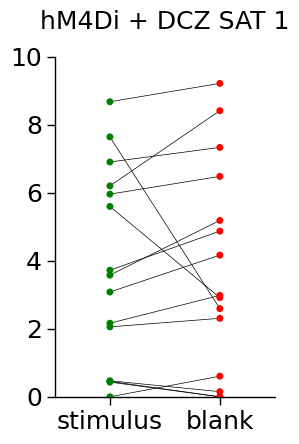

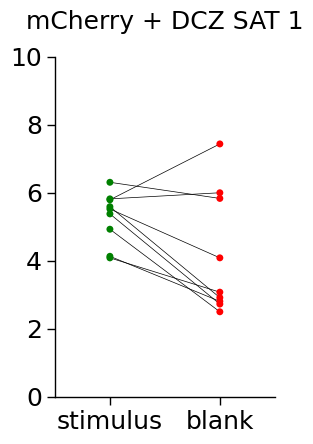

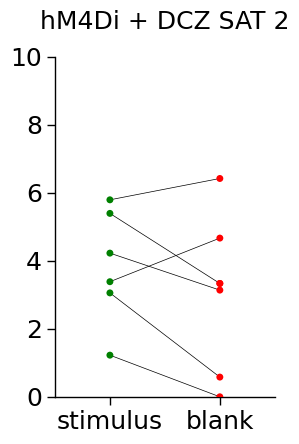

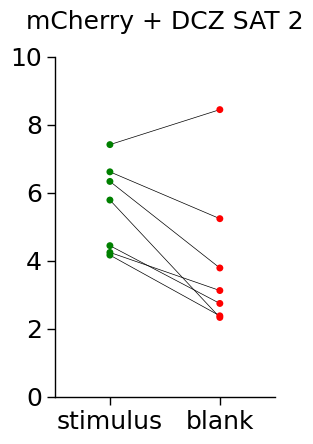

In [85]:
days = ['SAT 1', 'SAT 2']
dayfilt = last20_means[(last20_means.apply(lambda x: x['Day'] in days, axis=1))]
#cdfilt = dayfilt[dayfilt["cond"] == 'control']
for d in days:
    for c in ['hM4Di + DCZ', 'mCherry + DCZ']:
        plt_filt = last20_means[(last20_means['Day'] == d) & (last20_means['cond'] ==c)]
        if d =='SAT 1':
            # no data for these two animals at SAT1
            plt_filt = plt_filt[(plt_filt['animal'] != 'PIE8') & (plt_filt['animal'] != 'PIT11')]

        g = plot_pair_strip(plt_filt, y="lick",x="stimulus", order=["stimulus", "blank"],
                            hue="stimulus", palette=["green", "red"],
                            hue_order=["stimulus", "blank"], col='cond',
                            jitter=False, aspect=0.65, legend=False, connect=True)
        g.set_titles(c + ' ' + d)

In [99]:
res = []
firstlast20_means = last20_means.sort_values(['condition', 'animal', 'Day'])

stimcond = last20_means["stimulus"] == "stimulus"
blankcond = last20_means["stimulus"] == "blank"

conds = ['hM4Di + DCZ', 'mCherry + DCZ']
days = ['SAT 1', 'SAT 2']
filt = (firstlast20_means.apply(lambda x: x['cond'] in conds, axis=1)) & (firstlast20_means.apply(lambda x: x['Day'] in days, axis=1))
ind = firstlast20_means[filt][["cond", "Day"]].apply(tuple, axis=1).unique()

for c, day in ind:
    daycond = firstlast20_means["Day"] == day
    ccond = firstlast20_means["cond"] == c
    #print(firstlast20_means[daycond])
    stim = firstlast20_means[stimcond & daycond & ccond]["lick"]
    san = firstlast20_means[stimcond & daycond & ccond][['animal',"lick"]]
    blank = firstlast20_means[blankcond & daycond & ccond]["lick"]
    ban = firstlast20_means[blankcond & daycond & ccond][['animal',"lick"]]
    #print(day, c,'stim', san,'blank', ban, '\n')
    res.append(stats.mannwhitneyu(stim, blank, alternative='greater'))

pd.DataFrame(res, columns=["statistic", "pvalue"], index=pd.Series(ind).apply(lambda x: x[0] + ", " + x[1]))

,statistic,pvalue
"hM4Di + DCZ, SAT 1",115.0,0.586140
"hM4Di + DCZ, SAT 2",26.0,0.259871
"mCherry + DCZ, SAT 1",55.0,0.218971
"mCherry + DCZ, SAT 2",39.0,0.036422


In [47]:
final_incl = list(ant_means['animal'].unique())
final_incl.remove('PRP3')
final_incl.remove('PRP1')
ant_means = ant_means[(ant_means.apply(lambda x: x['animal'] in final_incl, axis=1)) & (ant_means['Time (hr)'] <= 48 ) & (ant_means['Time (hr)'] >= -24 )]
ant_perf = ant_perf[(ant_perf.apply(lambda x: x['animal'] in final_incl, axis=1))  & (ant_perf['Time (hr)'] <= 48 ) & (ant_perf['Time (hr)'] >= -24 )]
tots = tots[tots.apply(lambda x: x['animal'] in final_incl, axis=1) & (tots['Time (hr)'] <= 48 ) & (tots['Time (hr)'] >= -24 )]

c:\Users\swind\miniconda3\envs\behavior\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\swind\miniconda3\envs\behavior\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\swind\miniconda3\envs\behavior\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\swind\miniconda3\en

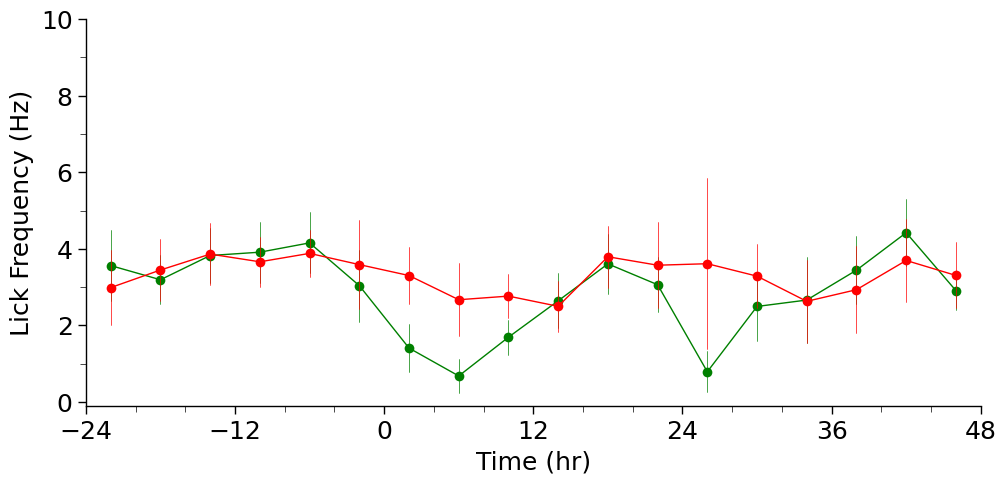

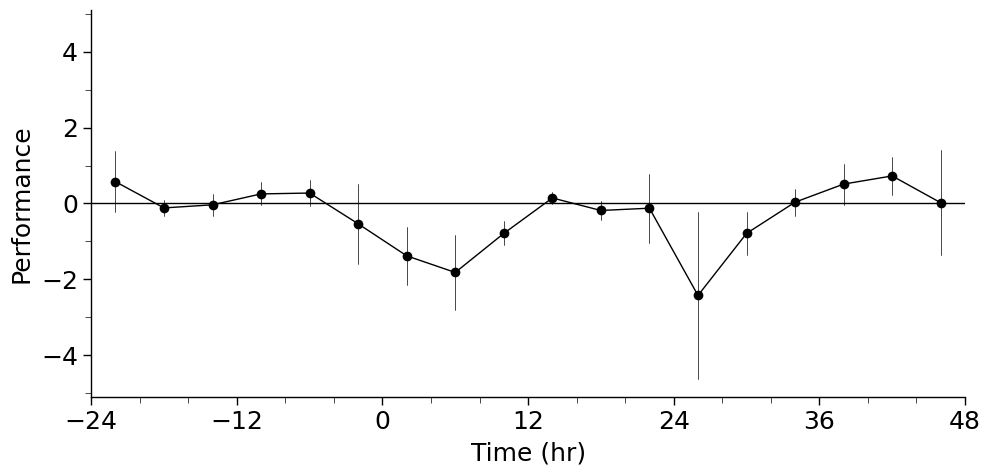

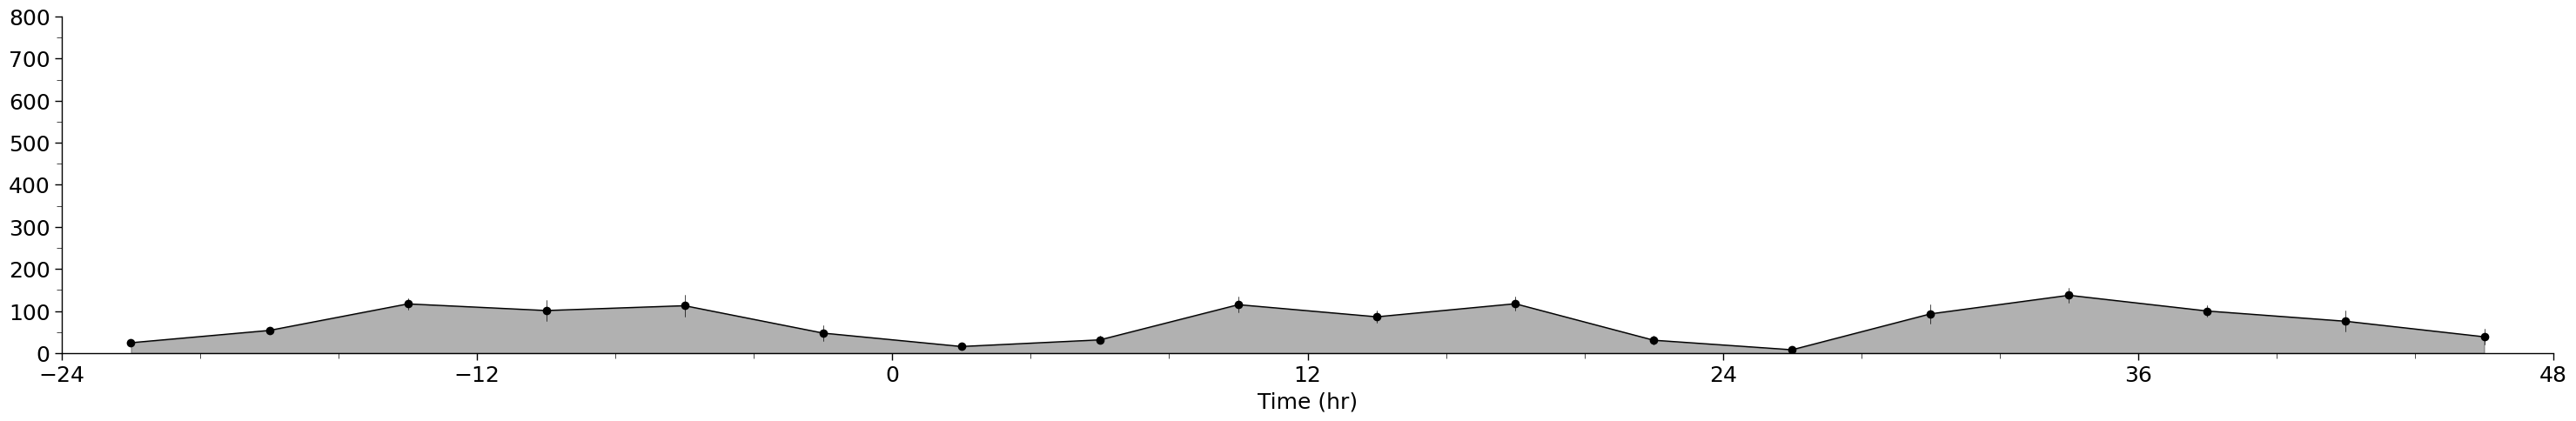

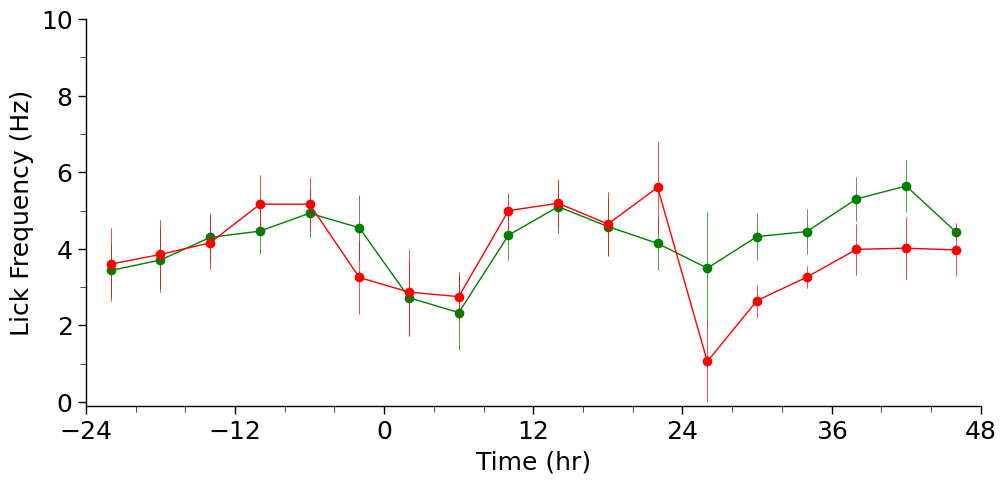

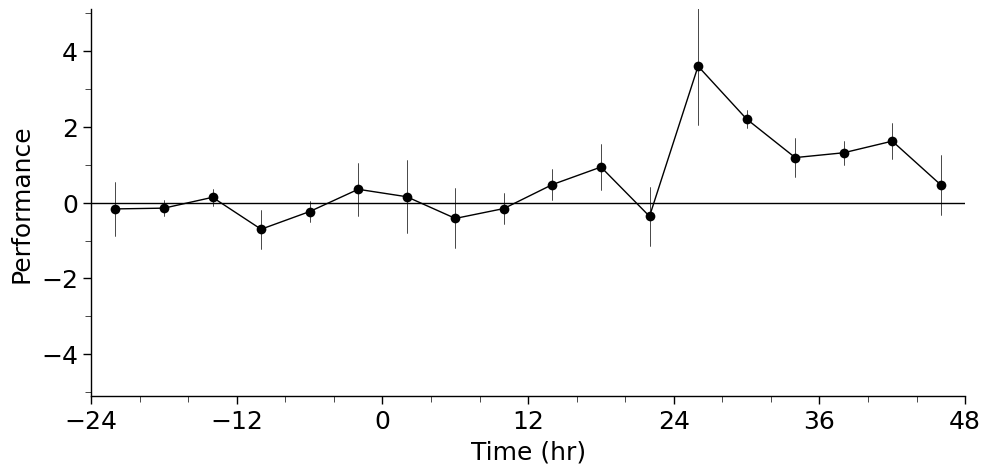

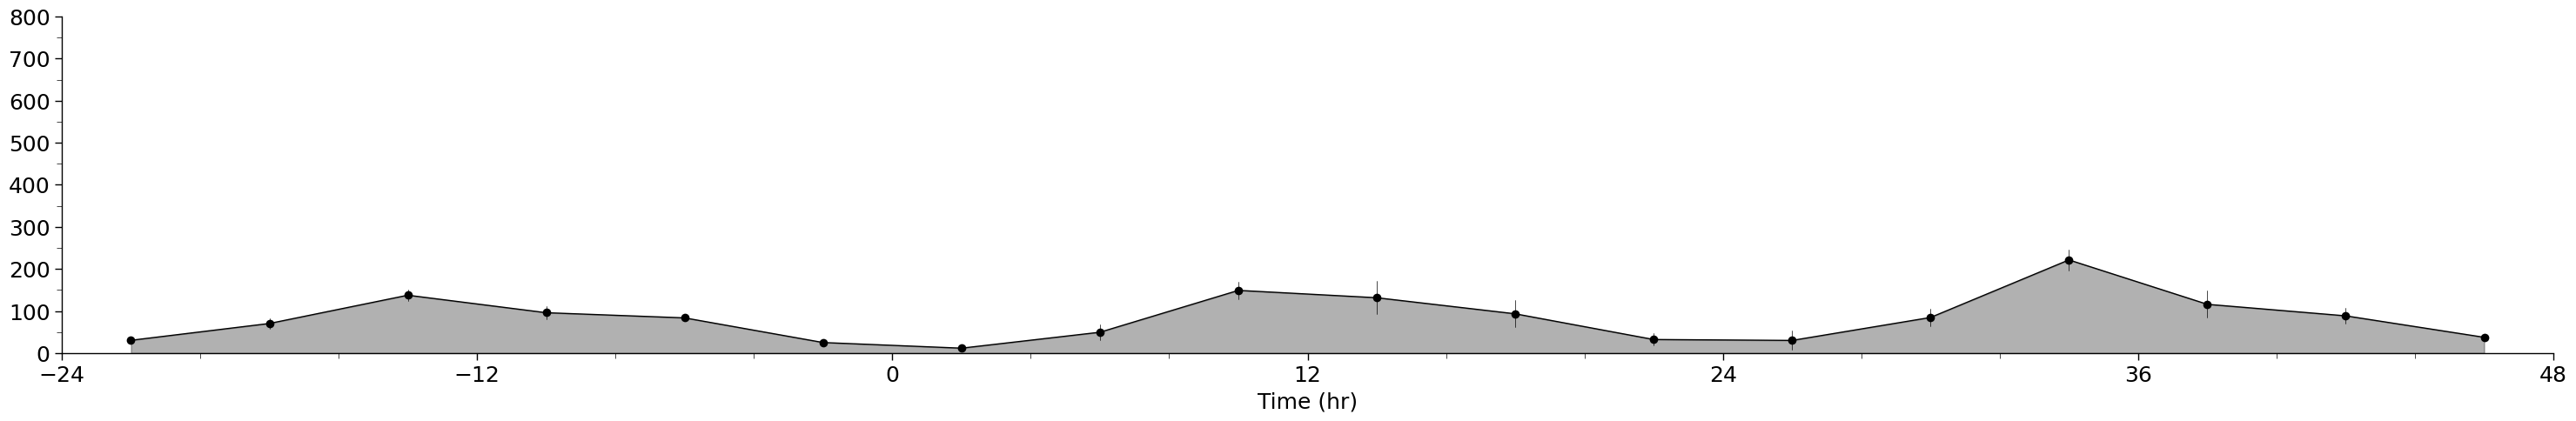

In [62]:
xlim = [-24, 48]
for c in ['hM4Di + DCZ', 'mCherry + DCZ']:
        g = plot_ant_lickfreq(ant_means[ant_means["cond"] == c],y='lick',aspect=2,lw=1, ms=7, title=c,col=None,
                                legend=False, xlim=xlim, ylim=[-0.1, 10], errorbar='se', err_style='bars', err_kws={"lw":0.5})
        g = plot_ant_perf(ant_perf[(ant_perf["cond"] == c)], ylabel="Performance", aspect=2,lw=1, ms=7,col=None,
                        xlim=xlim, legend=False, ylim=[-5.1, 5.1], title='',errorbar='se', err_style='bars', err_kws={"lw":0.5})
        g = plot_trial_hr(tots[(tots["cond"] == c)], xlim=xlim, col=None,
                        ylim=[0, 800], aspect=6, title='', ms=7, lw=1,err_kws={"lw":0.5}, ylabel='')